# DeepSphere using ModelNet40 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721) and others spherical CNNs
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from ModelNet40.load_MN40 import plot_healpix_projection, ModelNet40DatasetTF, ModelNet40DatasetCache

## 0.2 Define parameters

In [4]:
Nside = 32
exp='rot' # in ['rot', 'norot', 'pert', 'Z']
datapath = '../data/ModelNet40/' # localisation of the .OFF files
proc_path = datapath[1:]

In [375]:
augmentation = 3        # number of element per file (1 = no augmentation of dataset)
nfeat = 6

#### Test projection

In [205]:
import trimesh
mesh = trimesh.load_mesh(datapath+'airplane'+"/train/"+'airplane'+"_0119.off")
mesh.remove_degenerate_faces()
mesh.remove_duplicate_faces()
mesh.show()

In [6]:
from ModelNet40.load_MN40 import rotmat, rnd_rot

In [579]:
import trimesh
mesh = trimesh.load_mesh(datapath+'airplane'+"/train/"+'airplane'+"_0119.off")
mesh.remove_degenerate_faces()
mesh.fix_normals()
mesh.fill_holes()
mesh.remove_duplicate_faces()
mesh.remove_infinite_values()
mesh.remove_unreferenced_vertices()

mesh.apply_translation(-mesh.centroid)
r = np.max(np.linalg.norm(mesh.vertices, axis=-1))
mesh.apply_scale(1 / r)

mesh.apply_transform(rnd_rot(z=0, c=0))

r = np.max(np.linalg.norm(mesh.vertices, axis=-1))
mesh.apply_scale(0.99 / r)
mesh.remove_degenerate_faces()
mesh.fix_normals()
mesh.fill_holes()
mesh.remove_duplicate_faces()
mesh.remove_infinite_values()
mesh.remove_unreferenced_vertices()
mesh.show()


0.9885815631025242
[-0.97766942 -0.14502356  0.02059545]
0.9885815631025242
[-0.97766942 -0.14502356  0.02059545]


array([0.87274086, 0.8772296 , 0.8689643 , ..., 0.9011794 , 0.9047574 ,
       0.90344363], dtype=float32)

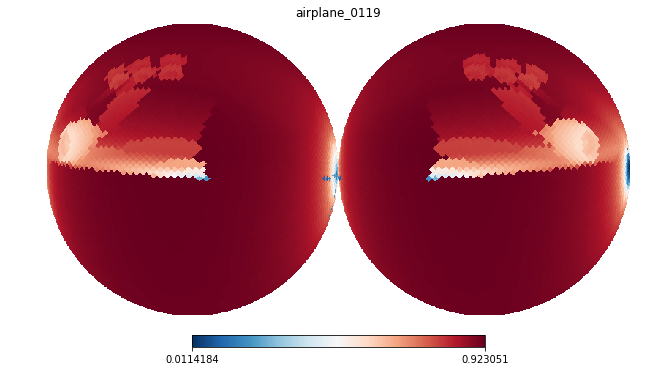

In [582]:
plot_healpix_projection(datapath+'airplane'+"/train/"+'airplane'+"_0119.off", 32, rotp = True, rot = (90,0,0))

array([0.88494617, 0.88560784, 0.884164  , ..., 0.8833286 , 0.8847804 ,
       0.88401675], dtype=float32)

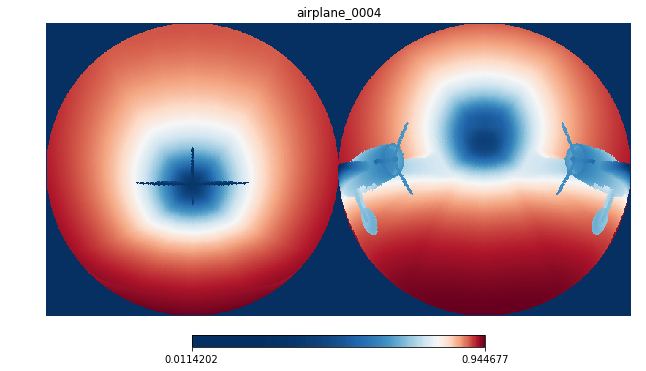

In [27]:
classes = ["airplane", "bathtub", "..."]
plot_healpix_projection(datapath+classes[0]+"/train/"+classes[0]+"_0004.off", 128, rotp = False, rot = (90,0,0))

## 1 Load dataset

In [48]:
train_rot_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, 
                                              experiment='deepsphere_rot_notr')


In [49]:
train_rot_tr_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, 
                                           experiment='deepsphere_rot')


In [50]:
train_tr_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, 
                                       experiment='deepsphere')


In [51]:
train_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=1, nfile=None, 
                                          experiment='deepsphere_notr')


In [510]:
train_Z_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, 
                                         experiment='deepsphere_Z')


Better to keep validation and testing set in RAM, but not always possible

In [248]:
test_tr_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None)

In [249]:
test_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, nfeat=nfeat, augmentation=1, nfile=None,
                                        experiment='deepsphere_notr')

In [250]:
test_rot_tr_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_rot', augmentation=3, nfile=None)

In [251]:
test_rot_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_rot_notr', augmentation=3, nfile=None)

In [496]:
test_Z_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_Z', augmentation=3, nfile=None)

Try do make a tensorflow dataset object

In [498]:
experiment = 'deepsphere'+('_rot' if exp == 'rot' else '')+('_Z' if exp == 'Z' else '')+('_notr' if 'pert' not in exp and exp != 'Z' else '')
train_TFDataset = ModelNet40DatasetTF(datapath, 'train', nside=Nside,
                                      nfeat=nfeat, augmentation=augmentation, nfile=None, experiment='deepsphere_Z')

In [425]:
train_TFDataset.N

29529

In [32]:
from ModelNet40.load_MN40 import compute_mean_std

In [493]:
compute_mean_std(train_Z_dataset, 'train', datapath, Nside)

100%|██████████| 9843/9843 [00:12<00:00, 803.95it/s]

[0.68086797 0.39995927 0.58512926 0.5349642  0.76186055 0.56521803]
[0.30230746 0.62314063 0.27418074 0.21441652 0.20090483 0.24440798]


In [408]:
dataset = train_TFDataset.get_tf_dataset(1)

  1%|          | 10/923 [00:02<03:12,  4.75it/s]/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  1%|          | 11/923 [00:02<03:06,  4.89it/s]


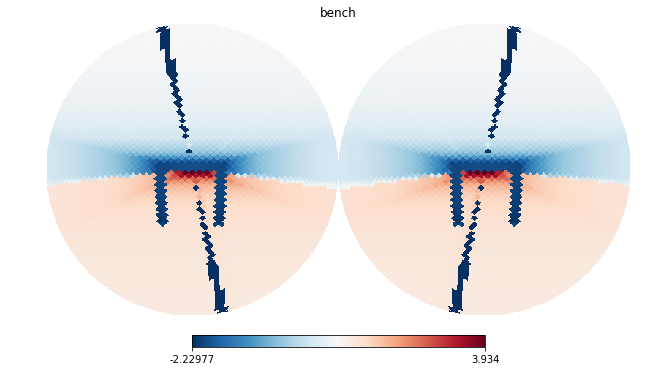

<Figure size 432x288 with 0 Axes>

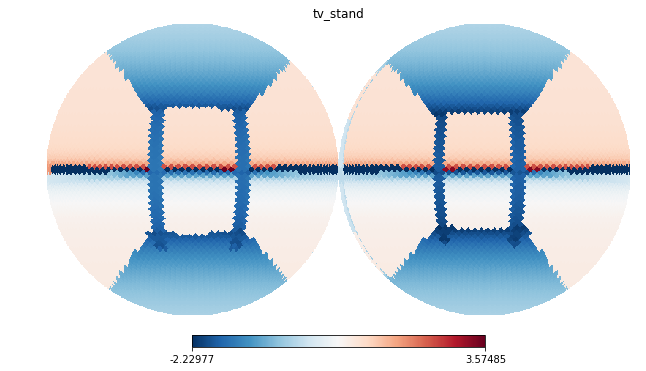

<Figure size 432x288 with 0 Axes>

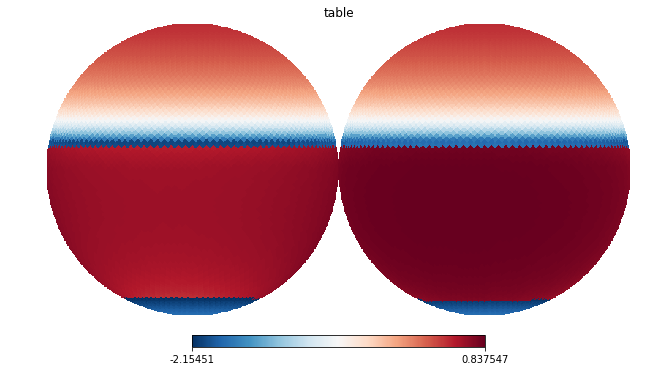

<Figure size 432x288 with 0 Axes>

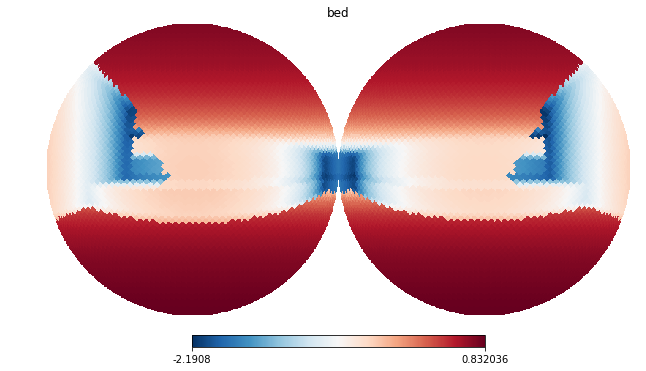

<Figure size 432x288 with 0 Axes>

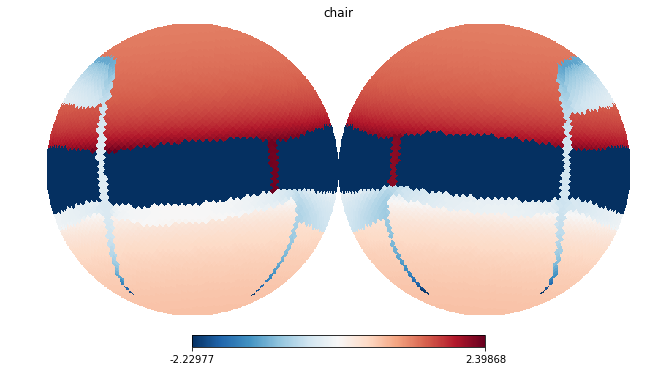

<Figure size 432x288 with 0 Axes>

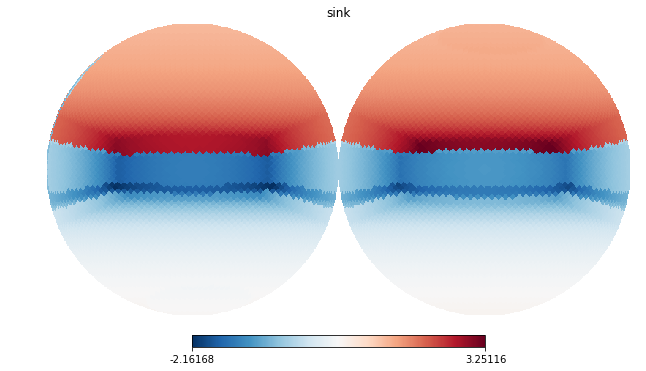

<Figure size 432x288 with 0 Axes>

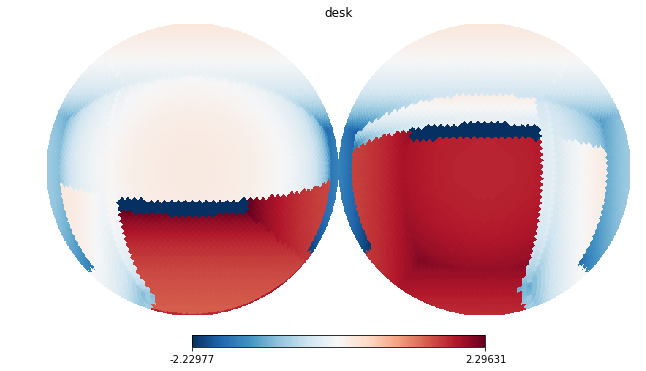

<Figure size 432x288 with 0 Axes>

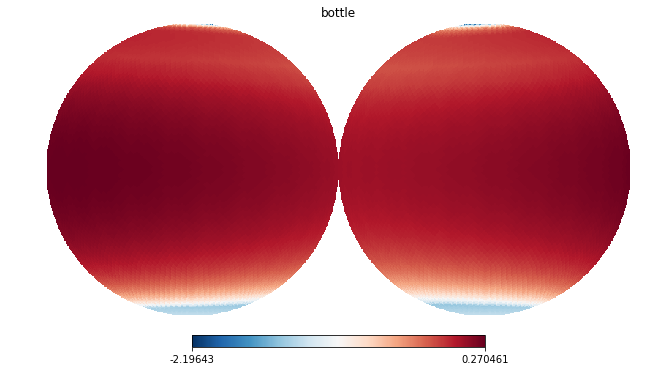

<Figure size 432x288 with 0 Axes>

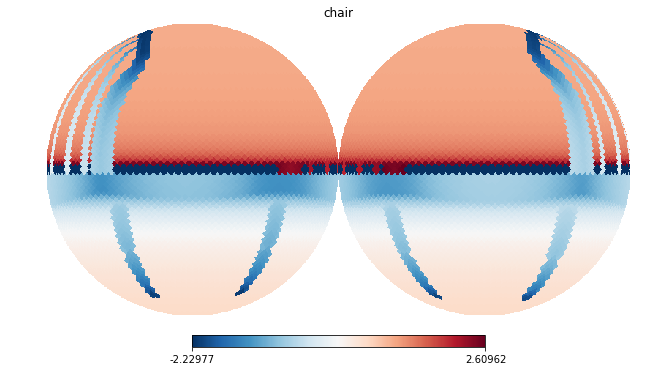

<Figure size 432x288 with 0 Axes>

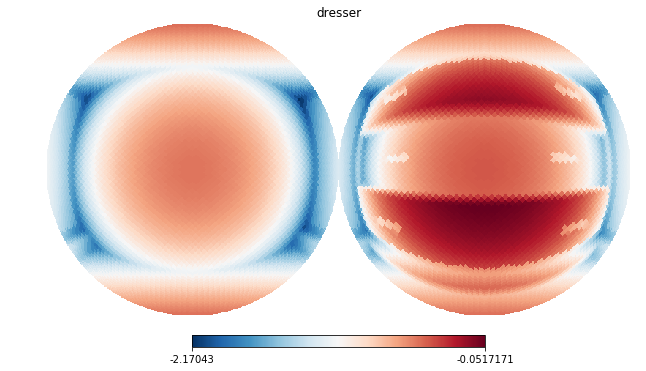

<Figure size 432x288 with 0 Axes>

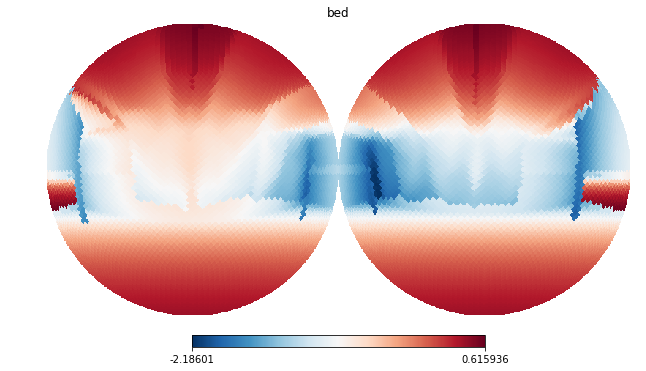

<Figure size 432x288 with 0 Axes>

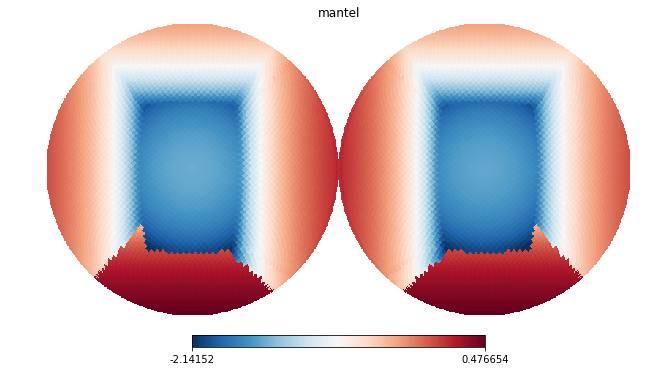

<Figure size 432x288 with 0 Axes>

In [409]:
import tensorflow as tf
from tqdm import tqdm

#dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
data_next = dataset.make_one_shot_iterator().get_next()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
steps = train_TFDataset.N // 32 + 1
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm(range(steps)):
        data, label = sess.run(data_next)
        im1 = data[0,:,0]
        cmin = np.nanmin(im1)
        cmax = np.nanmax(im1)
        hp.orthview(im1, rot=(0,0,0), title=test_no_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
        plt.figure()
        if i > 10:
            break
#     except tf.errors.OutOfRangeError:
#         print("Done") 

In [154]:
def transform(data, phi=None, theta=None):
    batch_size, npix, nfeat = data.shape
    if theta is None or phi is None:
        phi = np.random.rand() * 2 * np.pi
        theta = np.random.rand() * np.pi
    nside = hp.npix2nside(npix)

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(npix), nest=True) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[phi, theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    new_data = np.zeros(data.shape)
    for b in range(batch_size):
        for f in range(nfeat):
            new_data[b,:,f] = hp.get_interp_val(data[b,:,f], trot, prot, nest=True)

    return new_data

In [216]:
def transform_equator(data):
    return transform(data, 0, np.pi/2).astype(np.float32)

In [366]:
def transform_shift(data):
    batch_size, npix, nfeat = data.shape
    new_data = data.copy()
    nside = hp.npix2nside(npix)
    theta, _ = hp.pix2ang(nside, range(npix))
    theta_u = np.unique(theta)
    for b in range(batch_size):
        for f in range(nfeat):
            new_data[b, :, f] = hp.reorder(data[b, :, f], n2r=True)
            for t in theta_u:
                ligne_ind = np.where(theta==t)[0]
                ligne_ind_roll = np.roll(ligne_ind, len(ligne_ind)//4)
                new_data[b,ligne_ind_roll,f] = new_data[b,ligne_ind,f]
            new_data[b, :, f] = hp.reorder(new_data[b, :, f], r2n = True)
    return new_data

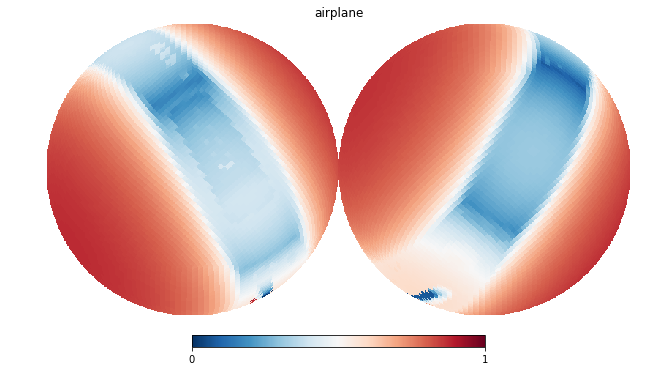

<Figure size 432x288 with 0 Axes>

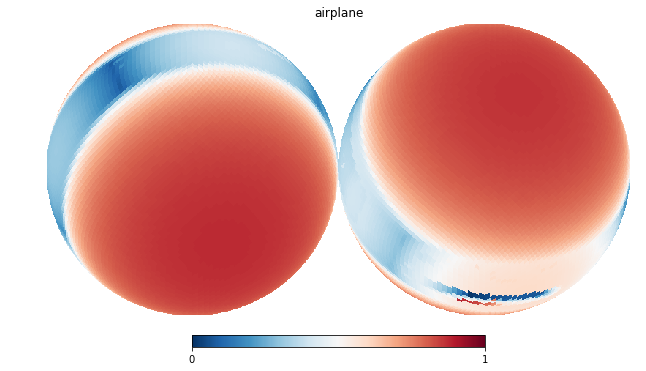

In [367]:
hp.orthview(im1[:,0], rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
plt.figure()
im2 = transform_shift(im1[np.newaxis,:,:])
hp.orthview(im2[0,:,0], rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)

In [504]:
from tqdm import tqdm
size = 1 # 32
steps = test_Z_dataset.N // size + 1
data_iter = test_Z_dataset.iter(size)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
    im1 = data[0,:,0]
    if np.std(im1)>2:
        print(np.std(im1))
        cmin = np.nanmin(im1)
        cmax = np.nanmax(im1)
        hp.orthview(im1, rot=(0,0,0), title=train_Z_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
        plt.figure()
#     if i > 10:
#         break


 39%|███▉      | 2903/7405 [00:05<00:08, 524.82it/s]
Exception in thread Thread-55:
Traceback (most recent call last):
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 7405/7405 [00:13<00:00, 532.22it/s]


In [ ]:
from tqdm import tqdm
steps = train_Z_dataset.N // 1 + 1
data_iter = train_Z_dataset.iter(1)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
    im1 = data[0,:,0]
    if np.std(im1)>2:
        print(np.std(im1))
        cmin = np.nanmin(im1)
        cmax = np.nanmax(im1)
        hp.orthview(im1, rot=(0,0,0), title=train_Z_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
        plt.figure()
#     if i > 1000:
#         break


  0%|          | 1/29530 [00:00<4:49:51,  1.70it/s]
Exception in thread Thread-58:
Traceback (most recent call last):
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|          | 38/29530 [02:33<33:08:24,  4.05s/it]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [426]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
print('number of class:',nclass,'\nnumber of elements:',num_elem)

number of class: 40 
number of elements: 29529


## 2 Classification using DeepSphere

In [499]:
EXP_NAME = 'MN40_Z_{}feat_{}aug_{}sides'.format(nfeat, augmentation, Nside)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = "shrec17_newGraph_best_4K_all_3aug_32sides_CNN"
#EXP_NAME = 'essai_TFDataset'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [500]:
params = hyperparameters.get_params_shrec17_optim(train_TFDataset.N, EXP_NAME, Nside, nclass, 
                                                  nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
# params["std"] = [0.001, 0.005, 0.0125, 0.05, 0.15, 0.5]
# params["full"] = [True]*6
model = models.deepsphere(**params)

#sides: [32, 16, 8, 4, 2, 1, 1]
#pixels: [12288, 3072, 768, 192, 48, 12, 12]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 3,628,523,520
Learning rate will start at 2.0e-02 and finish at 2.0e-02.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 6 * 16 * 4 = 384
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 4 = 2048
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 4 = 8192
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 192 * 128 / 4 = 6144
    weights: F_3 * F_4 * K_4 = 64 * 128 * 4 = 32768
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    

In [428]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [30]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
logits/weights:0
the number of parameters in the model is: 185,200


In [501]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(train_TFDataset, 
                                                                                 test_dataset, 
                                                                                 use_tf_dataset=True, cache=True)

KeyboardInterrupt: 

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


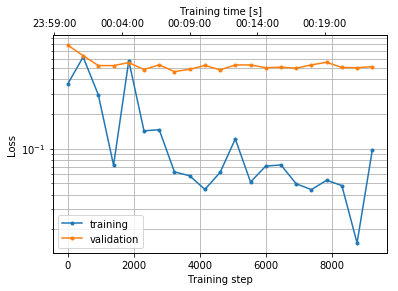

In [414]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [430]:
model.evaluate(train_rot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-5532


('accuracy: 96.56 (28513 / 29529), f1 (weighted): 96.55, loss: 1.15e-01\nCPU time: 91s, wall time: 86s',
 96.55931457211555,
 96.55205347595316,
 0.11546184201536695)

In [431]:
model.evaluate(train_rot_no_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-5532


('accuracy: 94.58 (27928 / 29529), f1 (weighted): 94.56, loss: 1.70e-01\nCPU time: 91s, wall time: 86s',
 94.57821124995766,
 94.55877300695255,
 0.17046240568282123)

In [432]:
model.evaluate(train_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-5532


('accuracy: 92.84 (27415 / 29529), f1 (weighted): 92.82, loss: 2.15e-01\nCPU time: 91s, wall time: 86s',
 92.84093602898845,
 92.82399450412814,
 0.21506925994068773)

In [433]:
model.evaluate(train_no_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-5532


('accuracy: 92.60 (9115 / 9843), f1 (weighted): 92.60, loss: 2.21e-01\nCPU time: 22s, wall time: 20s',
 92.60388093061059,
 92.600369824303,
 0.22073309215408848)

## test network

In [434]:
model.evaluate(test_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-5532


('accuracy: 84.51 (6257 / 7404), f1 (weighted): 84.74, loss: 5.76e-01\nCPU time: 23s, wall time: 22s',
 84.50837385197191,
 84.74148215471155,
 0.5755559670855731)

In [435]:
test_dataset.set_transform(transform_shift)
print(model.evaluate(test_dataset, None, cache=True))
test_dataset.set_transform(None)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-5532
('accuracy: 84.51 (6257 / 7404), f1 (weighted): 84.74, loss: 5.76e-01\nCPU time: 295s, wall time: 294s', 84.50837385197191, 84.74148215471155, 0.5755559655102241)


In [436]:
model.evaluate(test_rot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-5532


('accuracy: 85.63 (6340 / 7404), f1 (weighted): 85.77, loss: 5.37e-01\nCPU time: 24s, wall time: 22s',
 85.62938951917883,
 85.7705307750214,
 0.53684609505043)

In [437]:
model.evaluate(test_rot_no_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-5532


('accuracy: 86.21 (6383 / 7404), f1 (weighted): 86.34, loss: 5.22e-01\nCPU time: 23s, wall time: 22s',
 86.21015667206915,
 86.33933132816496,
 0.5217439768255272)

In [438]:
model.evaluate(test_no_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-5532


('accuracy: 84.32 (2081 / 2468), f1 (weighted): 84.60, loss: 5.92e-01\nCPU time: 6s, wall time: 6s',
 84.3192868719611,
 84.59691199605479,
 0.5918247983428669)

In [396]:
labels_test = test_rot_no_dataset.get_labels()

In [397]:
predictions, loss = model.predict(test_rot_no_dataset, None, cache=True)
print(loss)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_rot_6feat_3aug_32sides_CNN/model-6764
1.0913555974343028


In [295]:
elem_ = np.arange(len(labels_test))%3

In [293]:
plop = test_rot_no_dataset.files[labels_test != predictions]
class_pred = np.asarray(test_rot_no_dataset.classes)[predictions[labels_test != predictions].astype(int)]

0.541301
0.5440693
toilet
0.5413258
0.5416858
bookshelf
0.2346263
0.23985958
sink
0.23464477
0.23429967
bookshelf
0.23459713
0.23336655
range_hood
0.24064405
0.23843823
bench


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.24058111
0.2389528
bench
0.23630664
0.23597094
plant
0.23628058
0.2347498
toilet
0.2358029
0.24317463
toilet


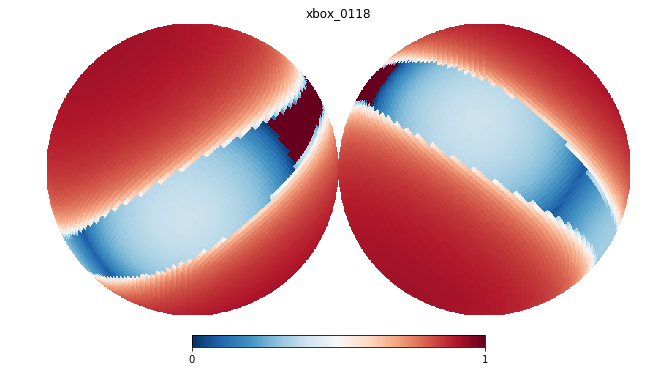

<Figure size 432x288 with 0 Axes>

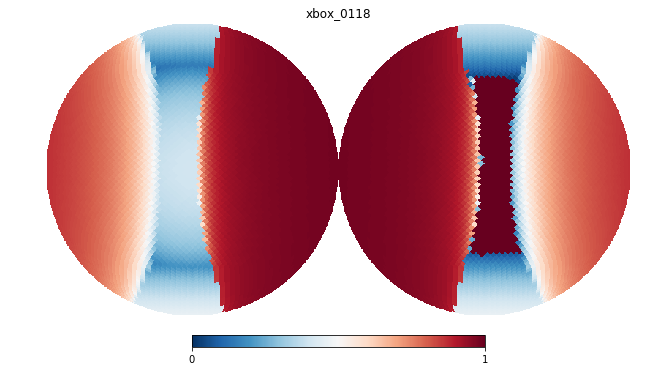

<Figure size 432x288 with 0 Axes>

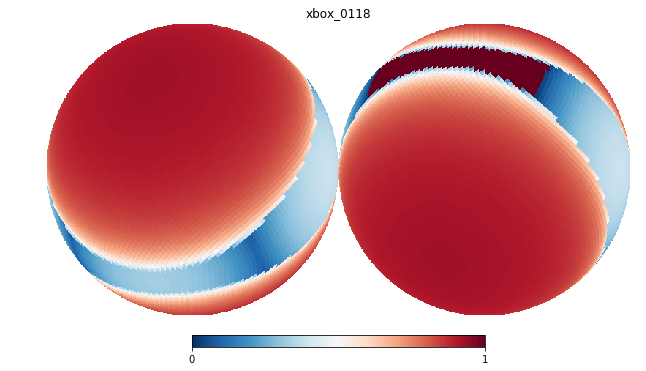

<Figure size 432x288 with 0 Axes>

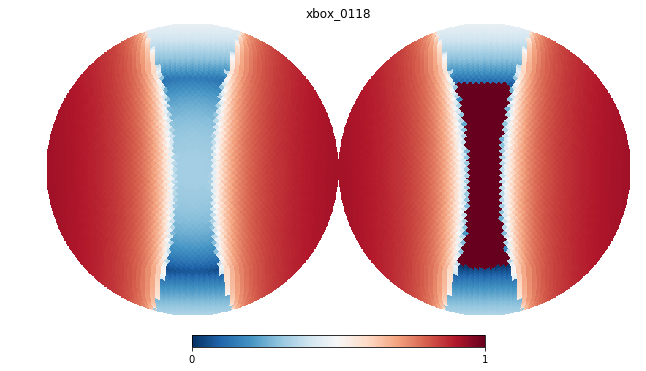

<Figure size 432x288 with 0 Axes>

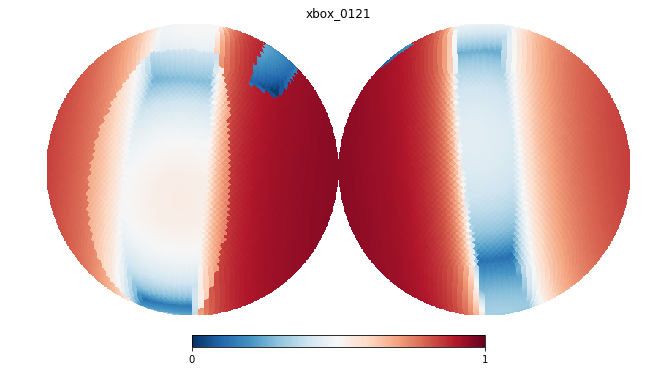

<Figure size 432x288 with 0 Axes>

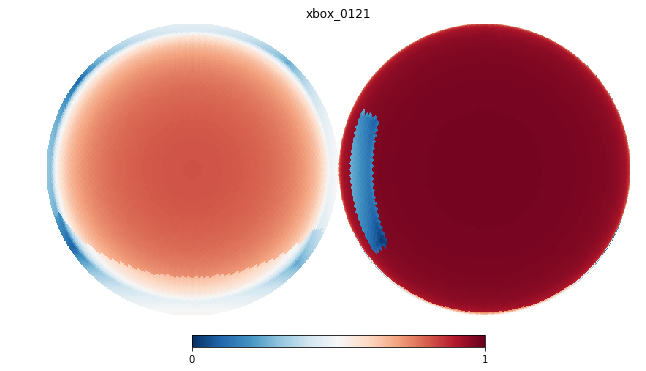

<Figure size 432x288 with 0 Axes>

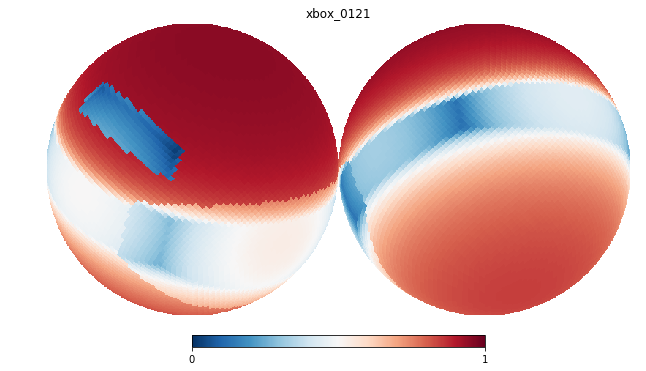

<Figure size 432x288 with 0 Axes>

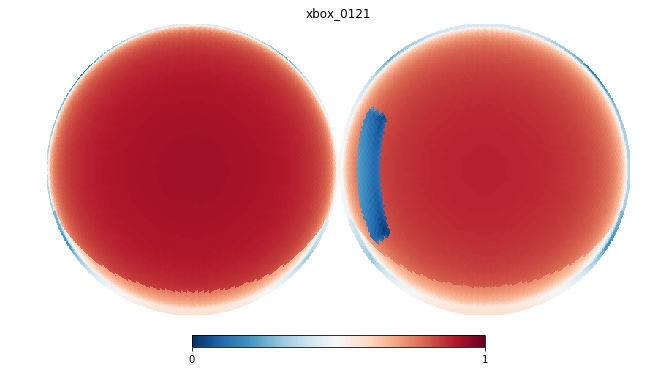

<Figure size 432x288 with 0 Axes>

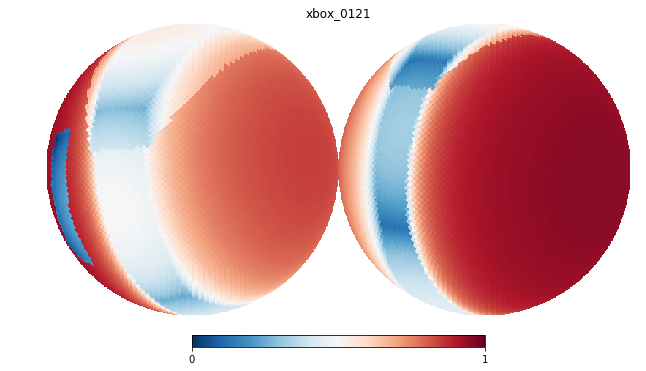

<Figure size 432x288 with 0 Axes>

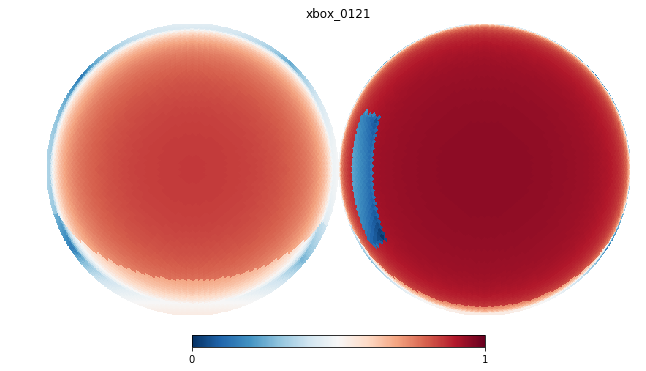

<Figure size 432x288 with 0 Axes>

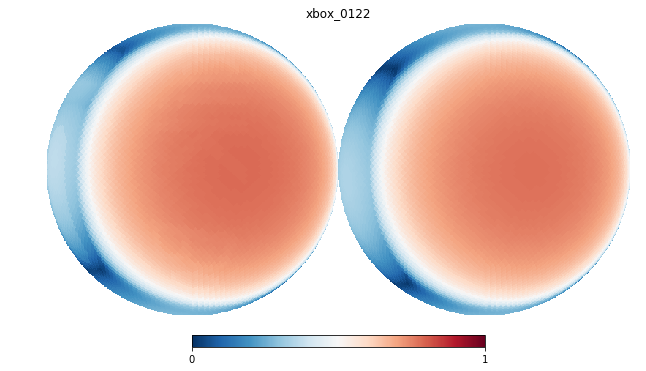

<Figure size 432x288 with 0 Axes>

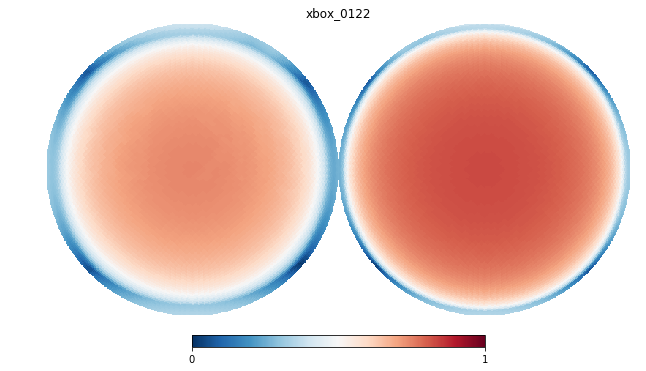

<Figure size 432x288 with 0 Axes>

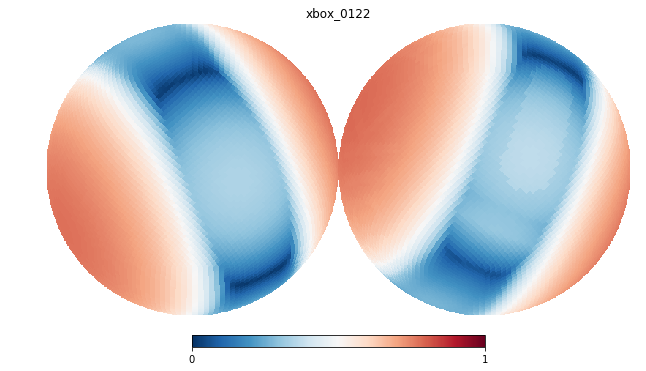

<Figure size 432x288 with 0 Axes>

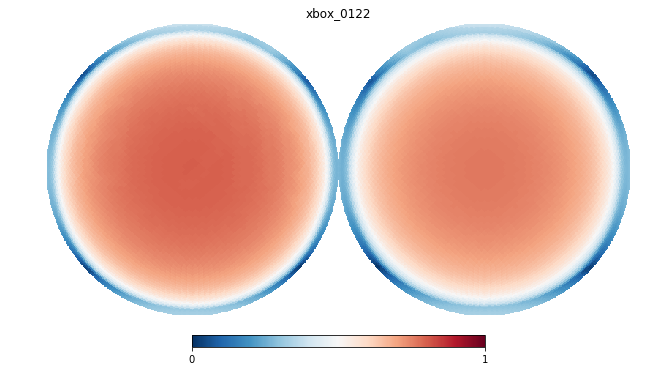

<Figure size 432x288 with 0 Axes>

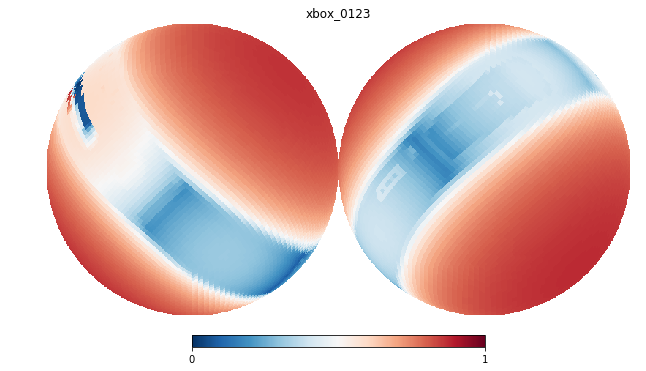

<Figure size 432x288 with 0 Axes>

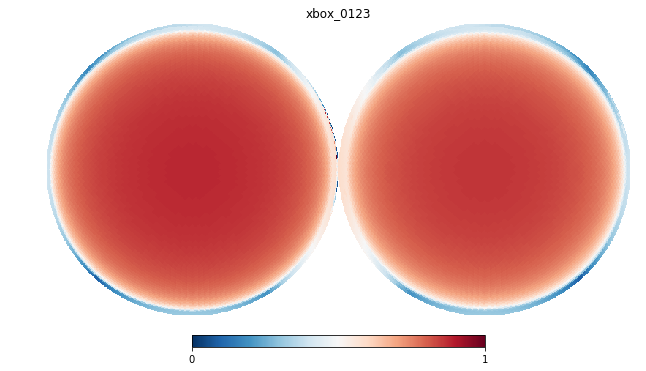

<Figure size 432x288 with 0 Axes>

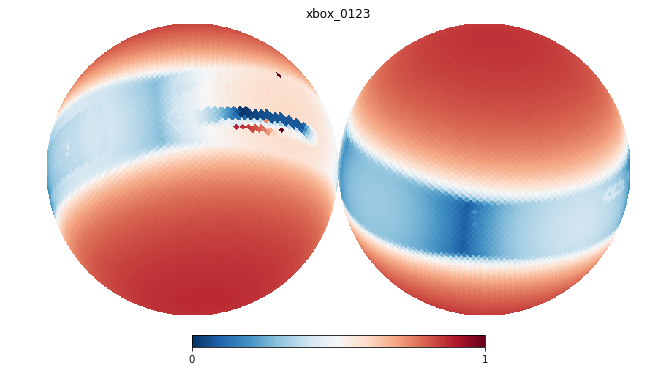

<Figure size 432x288 with 0 Axes>

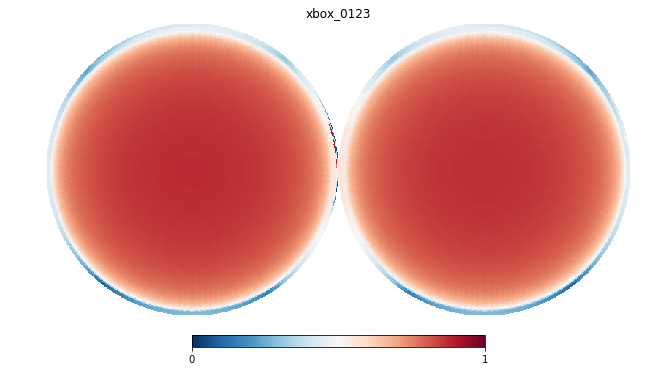

<Figure size 432x288 with 0 Axes>

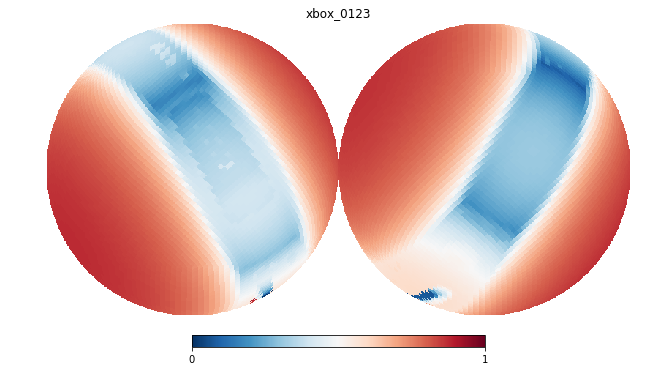

<Figure size 432x288 with 0 Axes>

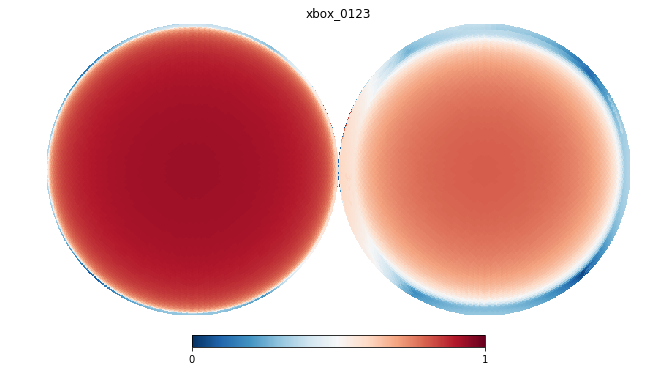

<Figure size 432x288 with 0 Axes>

In [312]:
for i, file in enumerate(plop[-10:]):
    suffix = os.path.splitext(os.path.split(file)[-1])[0]
#     pattern = "nside{}_{}_{}.npy".format(test_rot_no_dataset.nside, suffix, 0)
#     npy_path = os.path.join(test_rot_no.proc_dir, test_rot_no.experiment, pattern)
    data = test_rot_no_dataset.cache_npy(file, pick_randomly=False, 
                                         repeat=test_rot_no_dataset.repeat, experiment=test_rot_no_dataset.experiment)
    data2 = test_dataset.cache_npy(file, pick_randomly=False, 
                                         repeat=test_dataset.repeat, experiment=test_dataset.experiment)
    im1 = data[elem_[i]]
    im2 = data2[elem_[i]]
    print(np.std(im1))
    print(np.std(im2))
    print(class_pred[i])
    cmin = 0
    cmax = 1
    hp.orthview(im1[:,0], rot=(0,0,0), title=suffix, nest=True, cmap=cm, min=cmin, max=cmax)
    plt.figure()
    hp.orthview(im2[:,0], rot=(0,0,0), title=suffix, nest=True, cmap=cm, min=cmin, max=cmax)
    plt.figure()

Why not working?

In [196]:
def _print_histogram(nclass, labels_train, labels_min=None, ylim=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
    if labels_min is not None:
        hist_min = Counter(labels_min)
        hist_temp = hist_train - hist_min
        hist_min = hist_min - hist_train
        hist_train = hist_temp + hist_min
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    plt.ylim(0,ylim)
    #plt.xticks(indexes + width * 0.5, labels)
    plt.show()

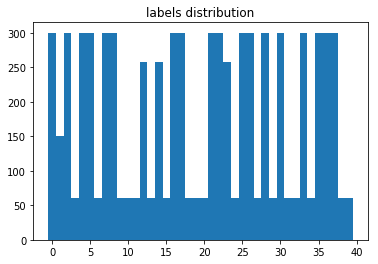

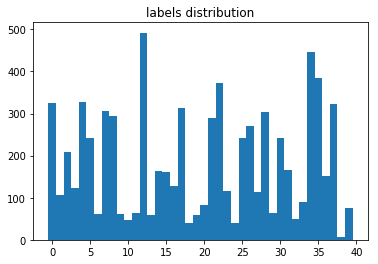

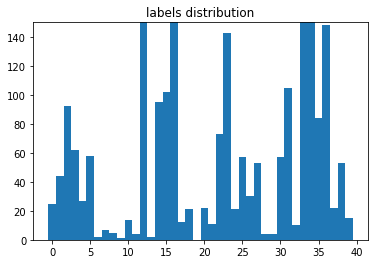

In [266]:
_print_histogram(40, labels_test)
_print_histogram(40, predictions)
_print_histogram(40, labels_test, predictions, ylim=150)

In [267]:
from sklearn.metrics import confusion_matrix

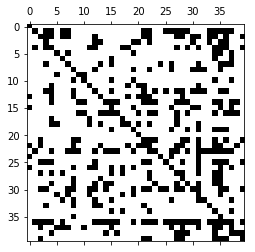

In [269]:
plt.spy(confusion_matrix(labels_test, predictions, range(40)), cmap = plt.cm.gist_heat_r)